In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 0. Loading & Verifying Sample Dataset

In [3]:
# Loading my 300k sample data
df = pd.read_parquet("../data/processed/cfpb_sample_300k.parquet")

In [6]:
print(f"Loaded {len(df):,} rows & {len(df.columns)} columns")

df.head()

Loaded 300,000 rows & 23 columns


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_quarter,geo,region,stratum,sample_n
0,2012-03-14,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,"BANK OF AMERICA, NATIONAL ASSOCIATION",ND,58503,...,2012-03-15,Closed with relief,Yes,No,35052,2012Q1,ND,Midwest,Bank account or service|2012Q1|Midwest,4
1,2012-03-20,Bank account or service,Checking account,Problems caused by my funds being low,None,None,None,TCF NATIONAL BANK,MN,55125,...,2012-03-21,Closed with relief,Yes,No,37573,2012Q1,MN,Midwest,Bank account or service|2012Q1|Midwest,4
2,2012-03-22,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,WELLS FARGO & COMPANY,MN,55110,...,2012-03-23,Closed without relief,Yes,Yes,39793,2012Q1,MN,Midwest,Bank account or service|2012Q1|Midwest,4
3,2012-03-07,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,Synovus Bank,OH,44108,...,2012-03-16,Closed without relief,Yes,No,34571,2012Q1,OH,Midwest,Bank account or service|2012Q1|Midwest,4
4,2012-03-20,Bank account or service,Checking account,Problems caused by my funds being low,None,None,None,PNC Bank N.A.,PA,18944,...,2012-03-23,Closed without relief,Yes,Yes,37047,2012Q1,PA,Northeast,Bank account or service|2012Q1|Northeast,6


It seems that the sample dataset loaded properly.

# 1. Checking Data

## 1.1 Addressing Data Types

In [8]:
# Basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Date received                 300000 non-null  datetime64[ns]
 1   Product                       300000 non-null  object        
 2   Sub-product                   294719 non-null  object        
 3   Issue                         300000 non-null  object        
 4   Sub-issue                     280187 non-null  object        
 5   Consumer complaint narrative  82855 non-null   object        
 6   Company public response       156950 non-null  object        
 7   Company                       300000 non-null  object        
 8   State                         298650 non-null  object        
 9   ZIP code                      299303 non-null  object        
 10  Tags                          15983 non-null   object        
 11  Consumer cons

We see that most columns take 'object' data type, i.e., string type. While this holds true for some features, several need to be addressed (converting to a more appropriate data type), such as:
- 'Date sent to company': String --> Datetime
- 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'year_quarter', 'geo', 'region', 'stratum': String --> Category
- 'Complaint ID': int64 --> int32

In [23]:
print(f"Memory before: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory before: 445.13 MB


In [26]:
# Target categorical columns (low-cardinality, repeated values)
cat_cols = [
    'Product', 'Sub-product', 'Issue', 'Sub-issue', 
    'Company public response', 'Company', 'State', 'ZIP code', 'Tags',
    'Consumer consent provided?', 'Submitted via', 
    'Company response to consumer', 'Timely response?', 'Consumer disputed?',
    'year_quarter', 'geo', 'region', 'stratum'
]

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Numeric tweaks
df['sample_n'] = df['sample_n'].astype('int32')  # If values fit
df['Complaint ID'] = df['Complaint ID'].astype('int32')

# Check cardinalities (should all be <10k unique for category to shine)
print("\nHigh-cardinality warnings:")
for col in cat_cols:
    if col in df.columns and df[col].nunique() > 10000:
        print(f"  {col}: {df[col].nunique():,} unique values")

print(f"Memory after: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


High-cardinality warnings:
  ZIP code: 16,584 unique values
Memory after: 118.74 MB


We can see that, re-assigning data types also saved us ~326 MB of memory (went from 445 MB to 119 MB), as a lot of the features were appropriately converted from higher-memory `str` to more efficient `category` data type.

## 1.2 Addressing Missing Values

In [28]:
print(f"Missing values:\n{df.isnull().sum().sort_values(ascending=False)}")

Missing values:
Tags                            284017
Consumer disputed?              282792
Consumer complaint narrative    217145
Company public response         143050
Consumer consent provided?       47576
Sub-issue                        19813
Sub-product                       5281
State                             1350
geo                               1350
ZIP code                           697
Timely response?                     0
stratum                              0
region                               0
year_quarter                         0
Complaint ID                         0
Date received                        0
Company response to consumer         0
Date sent to company                 0
Submitted via                        0
Product                              0
Company                              0
Issue                                0
sample_n                             0
dtype: int64


There's no solid way to imputing these null values; numeric imputation on categoricals is not practical. We'll keep these for now, and remove null-value rows based on specific EDA purposes later.

# 2. Exploratory Data Analysis (EDA)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

## 2.1 Univariate EDA

We start off with univariate analyses on some key variables.

### 2.1.1 Product Distribution

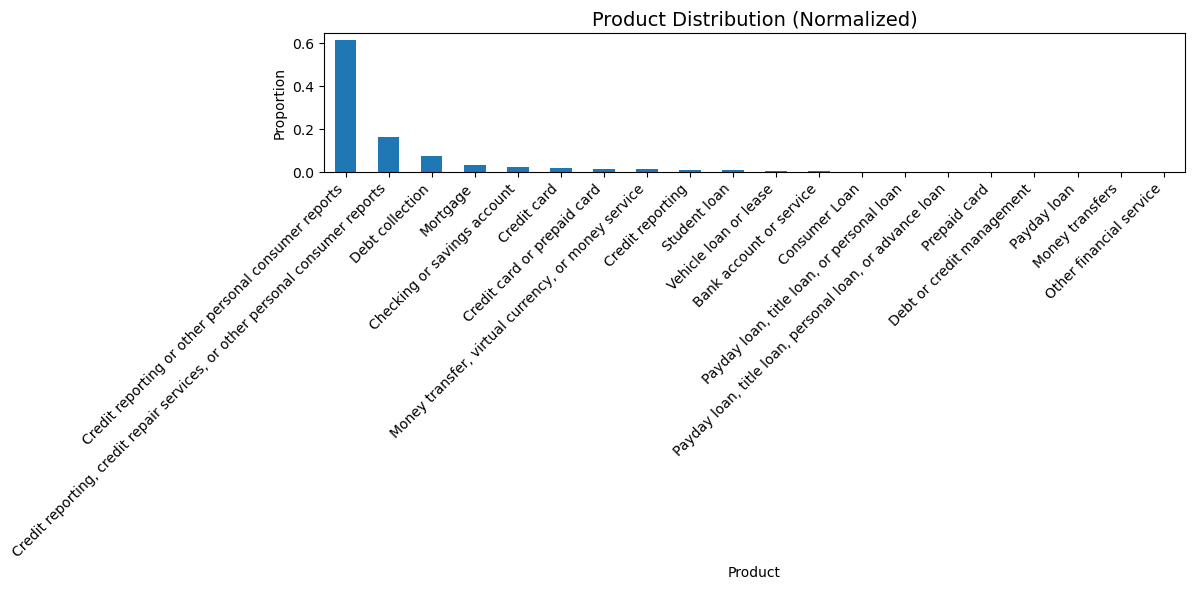

Top 5 Products:
Product
Credit reporting or other personal consumer reports                             184545
Credit reporting, credit repair services, or other personal consumer reports     48507
Debt collection                                                                  22223
Mortgage                                                                          9840
Checking or savings account                                                       7599
Name: count, dtype: int64


In [44]:
plt.figure(figsize=(12, 6))
df['Product'].value_counts(normalize=True).plot(kind='bar')
plt.title('Product Distribution (Normalized)', fontsize=14)
plt.ylabel('Proportion')
plt.xlabel('Product')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Top 5 Products:\n{df['Product'].value_counts().head()}")

### 2.1.2 Most-Occurring Companies

[KS to add: using Log scale b/c...]

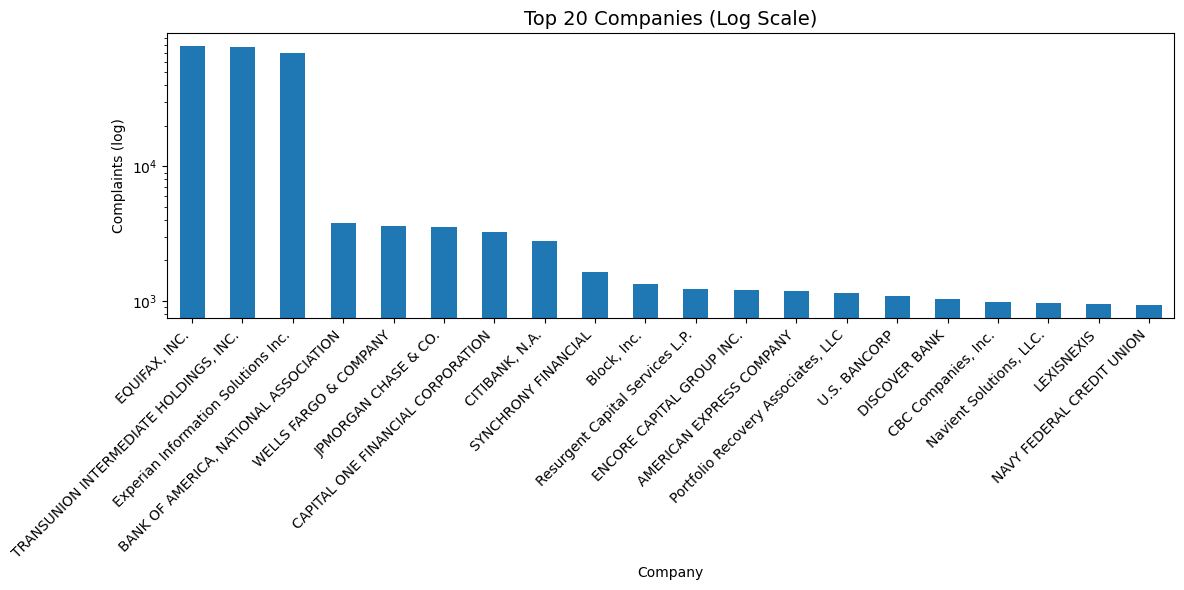

Total companies: 2,737
Top company share: 26.1%


In [46]:
plt.figure(figsize=(12, 6))
top_companies = df['Company'].value_counts().head(20)
top_companies.plot(kind='bar', logy=True)
plt.title('Top 20 Companies (Log Scale)', fontsize=14)
plt.ylabel('Complaints (log)')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Total companies: {df['Company'].nunique():,}")
print(f"Top company share: {top_companies.iloc[0]/len(df):.1%}")

### 2.1.3 Most-Occurring Issues

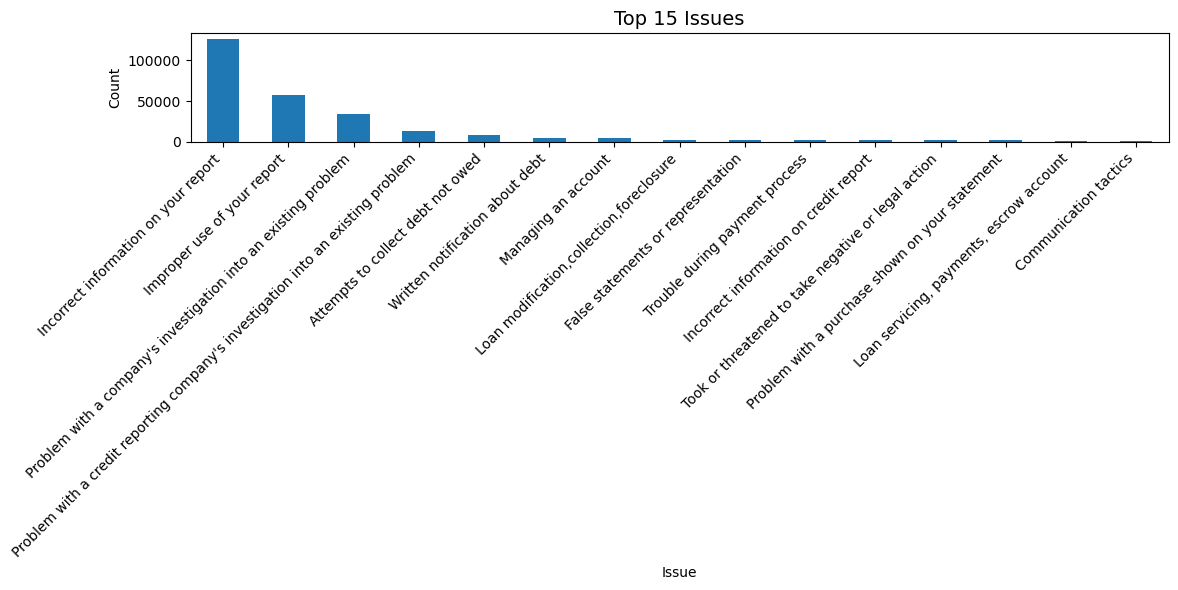

Top 5 Issues:
Issue
Incorrect information on your report                                                126774
Improper use of your report                                                          57528
Problem with a company's investigation into an existing problem                      34785
Problem with a credit reporting company's investigation into an existing problem     13273
Attempts to collect debt not owed                                                     8578
Name: count, dtype: int64


In [51]:
plt.figure(figsize=(12, 6))
top_issues = df['Issue'].value_counts().head(15)
top_issues.plot(kind='bar')
plt.title('Top 15 Issues', fontsize=14)
plt.ylabel('Count')
plt.xlabel('Issue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Top 5 Issues:\n{top_issues.head()}")

### 2.1.4 Complaints' Trend Over Time

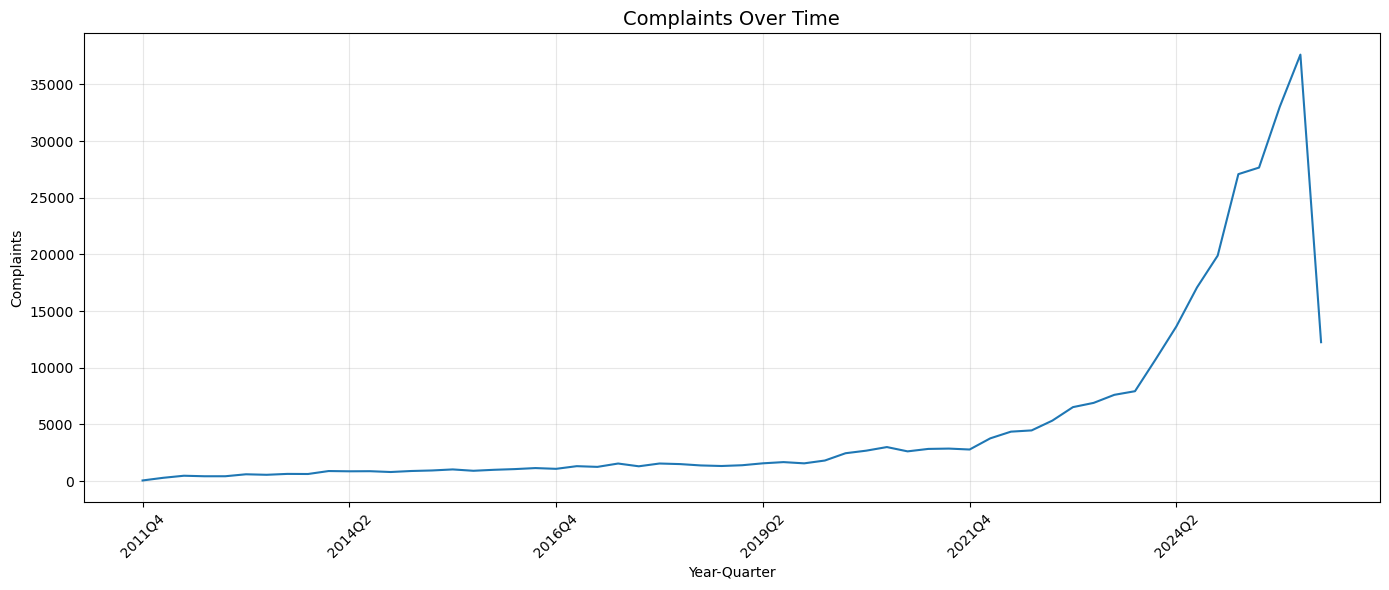

Trend: Growing


In [52]:
plt.figure(figsize=(14, 6))
time_counts = df['year_quarter'].value_counts().sort_index()
time_counts.plot()
plt.title('Complaints Over Time', fontsize=14)
plt.ylabel('Complaints')
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Trend:", "Growing" if time_counts.iloc[-1] > time_counts.iloc[0] else "Stable/Declining")

### 2.1.5 Complaints by Geography (Region)

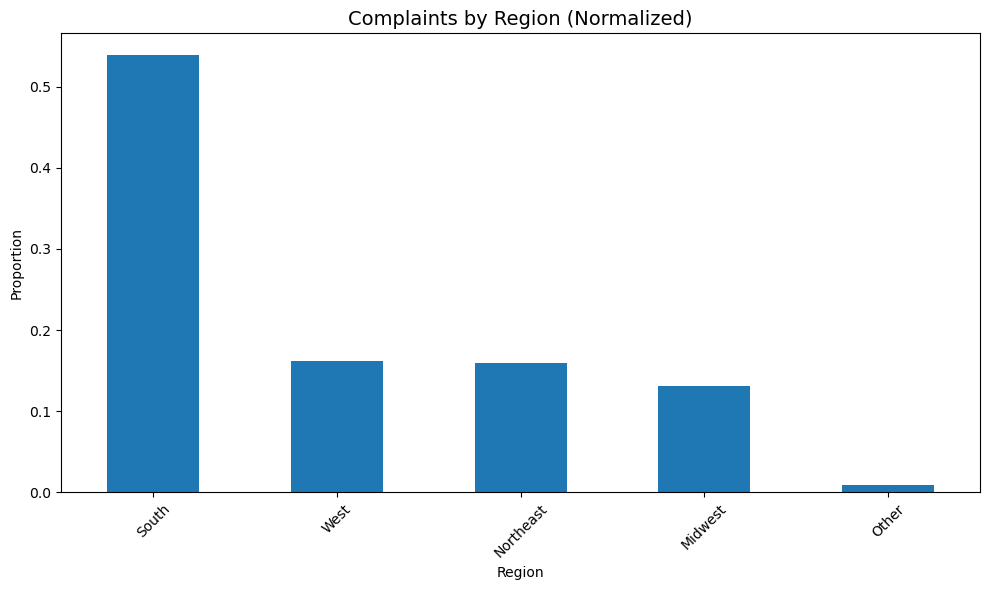

In [54]:
plt.figure(figsize=(10, 6))
df['region'].value_counts(normalize=True).plot(kind='bar')
plt.title('Complaints by Region (Normalized)', fontsize=14)
plt.ylabel('Proportion')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.1.6 Submission Channel

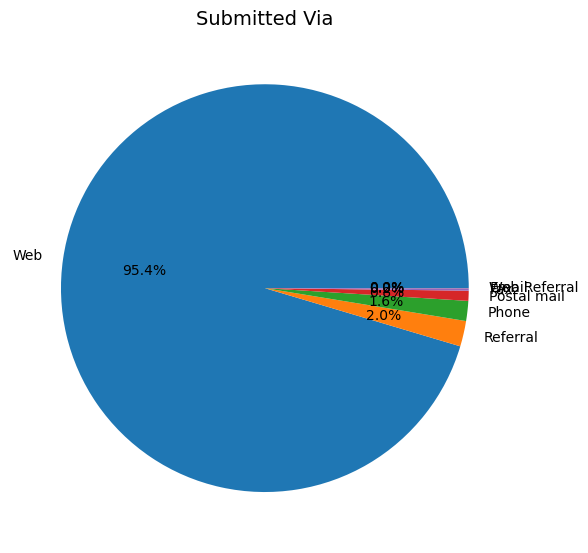

In [56]:
plt.figure(figsize=(6, 6))
df['Submitted via'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Submitted Via', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

### 2.1.7 Response Outcomes

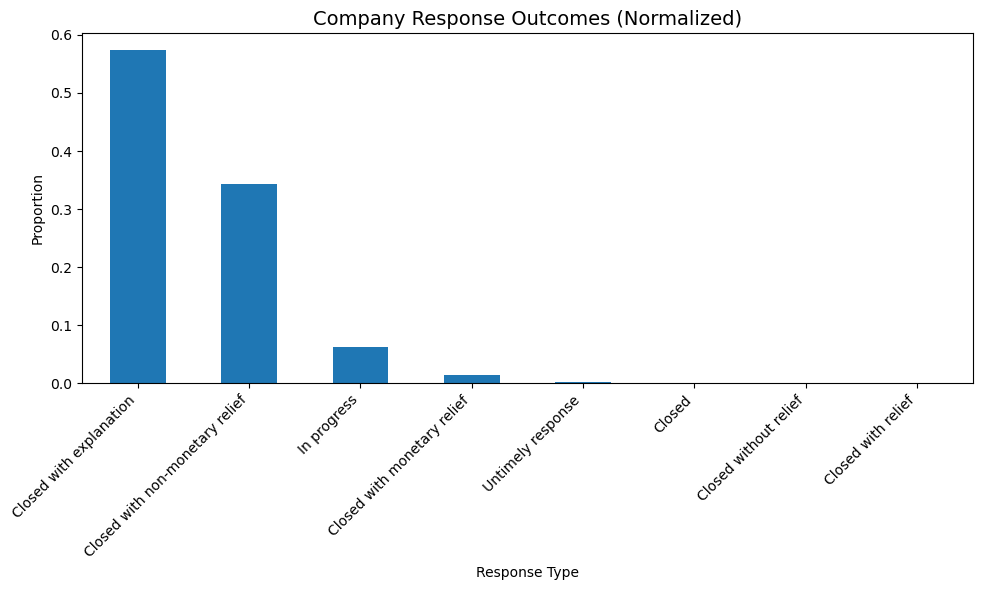

In [57]:
plt.figure(figsize=(10, 6))
df['Company response to consumer'].value_counts(normalize=True).plot(kind='bar')
plt.title('Company Response Outcomes (Normalized)', fontsize=14)
plt.ylabel('Proportion')
plt.xlabel('Response Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.1.8 Narrative Analyses

#### 2.1.8.1 Narrative Length

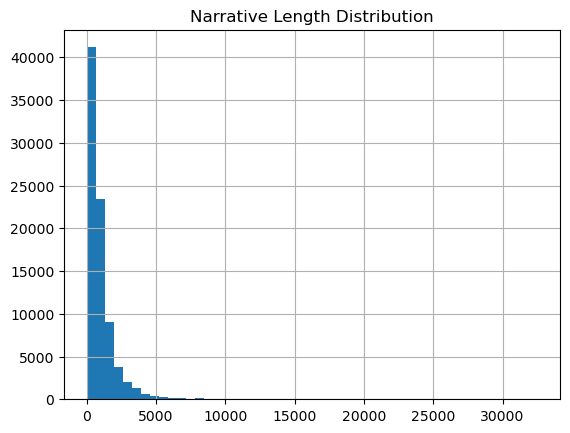

In [88]:
narrative_df = df[df['Consumer complaint narrative'].notna()]
narrative_df['narrative_len'] = narrative_df['Consumer complaint narrative'].str.len()
narrative_df['narrative_len'].hist(bins=50)
plt.title('Narrative Length Distribution')
plt.show()

### 2.1.8 Summary of Univariate EDA

[KS to investigate reasonings behind the findings as needed and beef up this section]
- Credit reporting: 62%+ of complaints --> Credit as #1 product
​- Company concentration: Top 1 = 26% (2.7k total) --> Few giants, long tail
- Issues: Report errors/investigations --> Credit reporting issues dominate
- Time: Sharp growth in recent quarters -->	Post-COVID + rate hikes? [KS to investigate and add findings]
​- Submission channel: Web as 95% submissions' means --> Confirms digital shift
- Region: South-heavy

## 2.2 Bivariate EDA (Cross-tabs)

### 2.2.1 Top Products × Issue

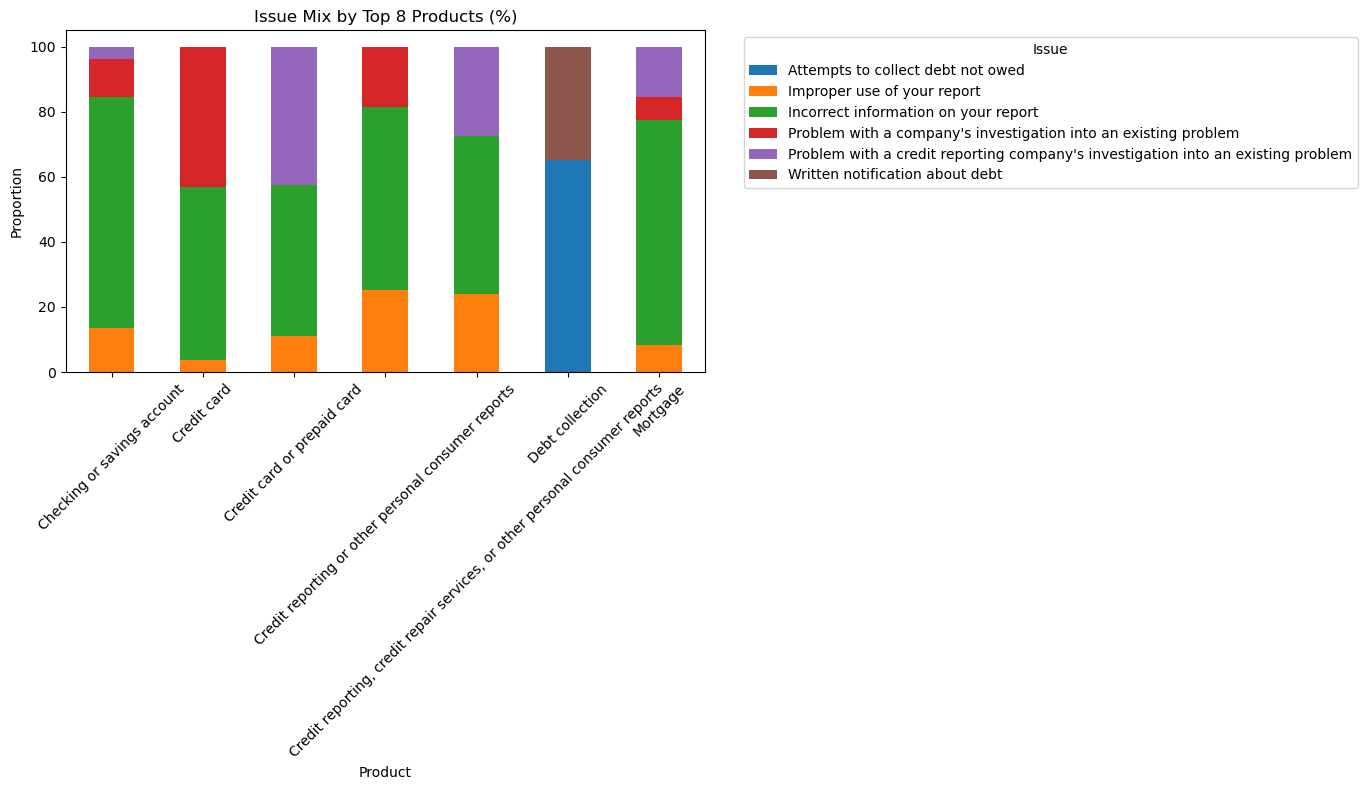

In [85]:
top_prods = df['Product'].value_counts().head(8).index
top_issues = df['Issue'].value_counts().head(6).index

subset = df[df['Product'].isin(top_prods) & df['Issue'].isin(top_issues)]
pivot_stack = pd.crosstab(subset['Product'], subset['Issue'], normalize='index') * 100

pivot_stack.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Issue Mix by Top 8 Products (%)')
plt.ylabel('Proportion')
plt.xlabel('Product')
plt.legend(title='Issue', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.2.2 Response Outcomes

Response breakdown:
 Company response to consumer
Closed with explanation            0.573930
Closed with non-monetary relief    0.343470
In progress                        0.063183
Closed with monetary relief        0.014620
Untimely response                  0.001720
Closed                             0.001360
Closed without relief              0.001317
Closed with relief                 0.000400
Name: proportion, dtype: float64


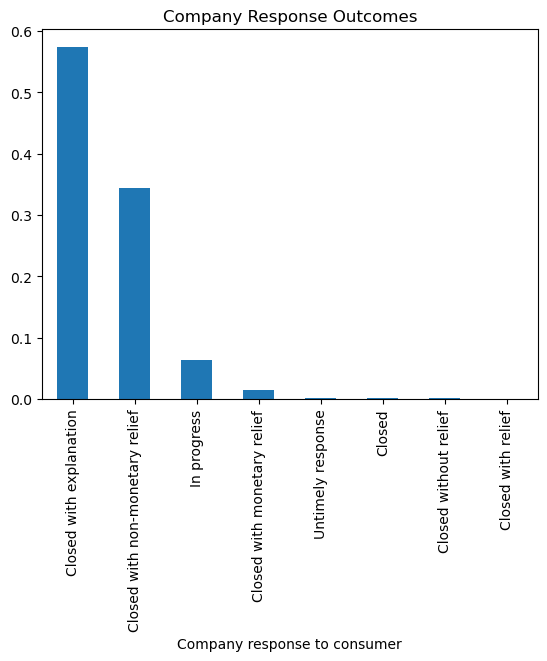

In [63]:
response_table = df['Company response to consumer'].value_counts(normalize=True)
print("Response breakdown:\n", response_table)
response_table.plot(kind='bar')
plt.title('Company Response Outcomes')
plt.xticks(rotation=90)
plt.show()

'Closed with explanation' dominates with 57%+, followed by 'Closed with non-monetary relief' with 34%+. Overall, total issues closed were 93.4%, which is good. [KS to add...]

### 2.2.3 Timeliness by Product

Timely response rate by Product:
 Product
Credit reporting or other personal consumer reports                             99.9
Credit reporting                                                                99.7
Credit reporting, credit repair services, or other personal consumer reports    99.6
Credit card                                                                     99.6
Money transfers                                                                 99.1
Checking or savings account                                                     99.0
Credit card or prepaid card                                                     98.9
Money transfer, virtual currency, or money service                              98.4
Mortgage                                                                        98.1
Vehicle loan or lease                                                           98.1
Bank account or service                                                         96.9
Payday loan, title loan

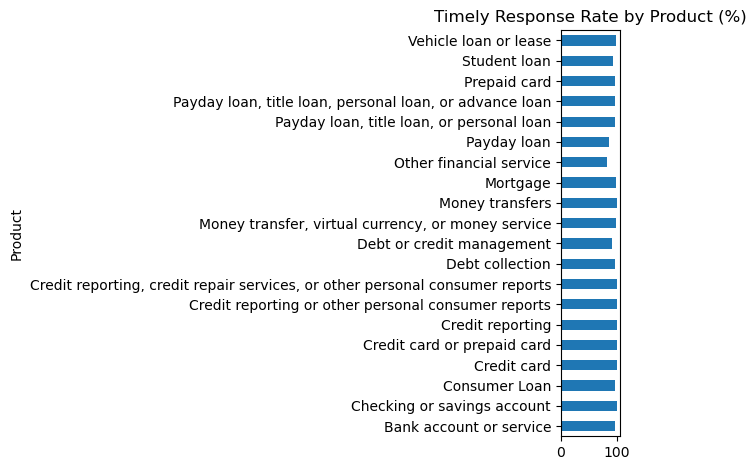

In [60]:
timely_pivot = df.groupby(['Product', 'Timely response?']).size().unstack(fill_value=0)
timely_pivot['Yes_%'] = timely_pivot['Yes'] / (timely_pivot['Yes'] + timely_pivot['No']) * 100
print("Timely response rate by Product:\n", timely_pivot['Yes_%'].sort_values(ascending=False).round(1))
timely_pivot['Yes_%'].plot(kind='barh', title='Timely Response Rate by Product (%)')
plt.tight_layout()
plt.show()

Vehicle loans came up with surprisingly high timeliness. [KS to add more...]

### 2.2.4 Product × Channel

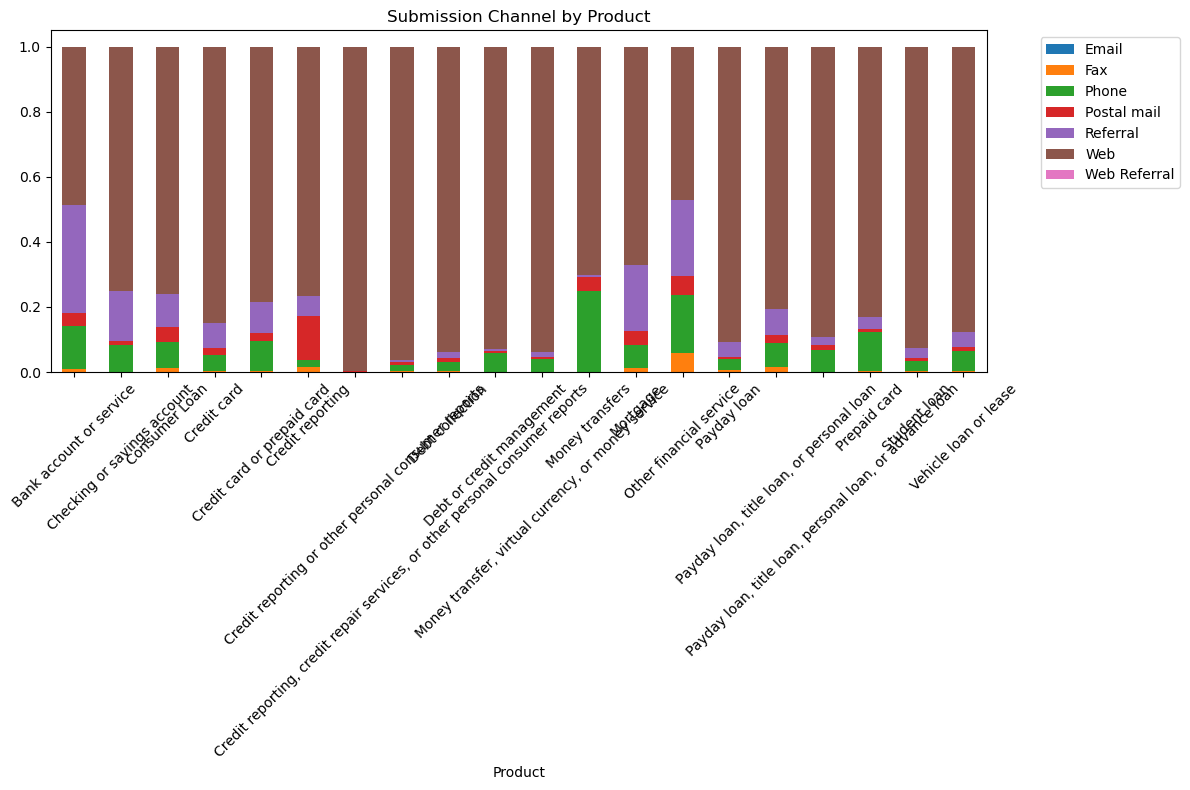

In [65]:
# Use numeric crosstab
channel_pivot = pd.crosstab(df['Product'], df['Submitted via'], normalize='index')
channel_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Submission Channel by Product')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As we can see, product-wise complaints-submission-channel exhibited 95% for web; phone/referral for niche products only. [KS to add...]

### 2.2.5 Recent growth drill-down

Recent product shift:
 Product
Credit reporting or other personal consumer reports        0.904764
Debt collection                                            0.049307
Credit card                                                0.014393
Checking or savings account                                0.011956
Money transfer, virtual currency, or money service         0.005562
Mortgage                                                   0.004029
Vehicle loan or lease                                      0.003535
Student loan                                               0.002606
Payday loan, title loan, personal loan, or advance loan    0.002268
Prepaid card                                               0.000977
Name: proportion, dtype: float64


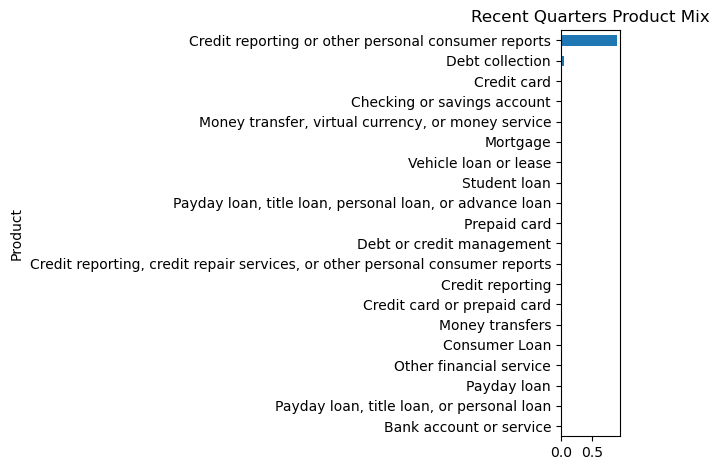

In [79]:
df['year_quarter_str'] = df['year_quarter'].astype(str) # Converted to string for comparison

recent = df[df['year_quarter_str'] >= '2025Q3']
print("Recent product shift:\n", recent['Product'].value_counts(normalize=True).head(10))
recent['Product'].value_counts(normalize=True).plot(kind='barh', title='Recent Quarters Product Mix')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

[Credit reporting 90.5% now (vs 62% overall) → massive shift] [KS to play around with the quarters, extend time coverage to represent recent times...]

### 2.2.6 Company + Timeliness + Geography

#### 2.2.6.1 Top Companies for Credit Reporting Issue

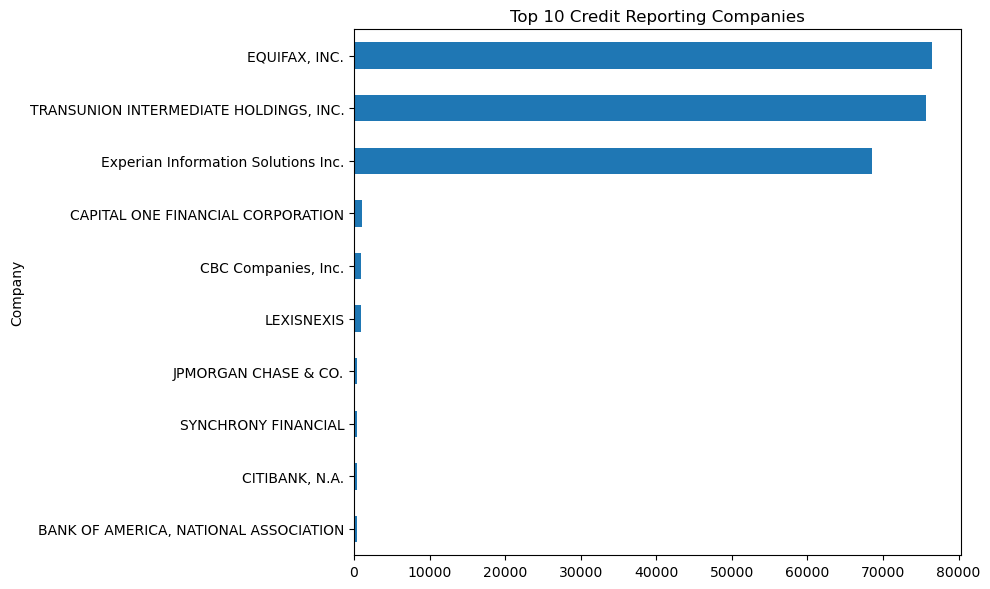

In [ ]:
credit_df = df[df['Product'].str.contains('Credit reporting', na=False)]
top_credit_cos = credit_df['Company'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_credit_cos.plot(kind='barh')
plt.title('Top 10 Credit Reporting Companies')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

#### 2.2.6.2 Response Timeliness by Product

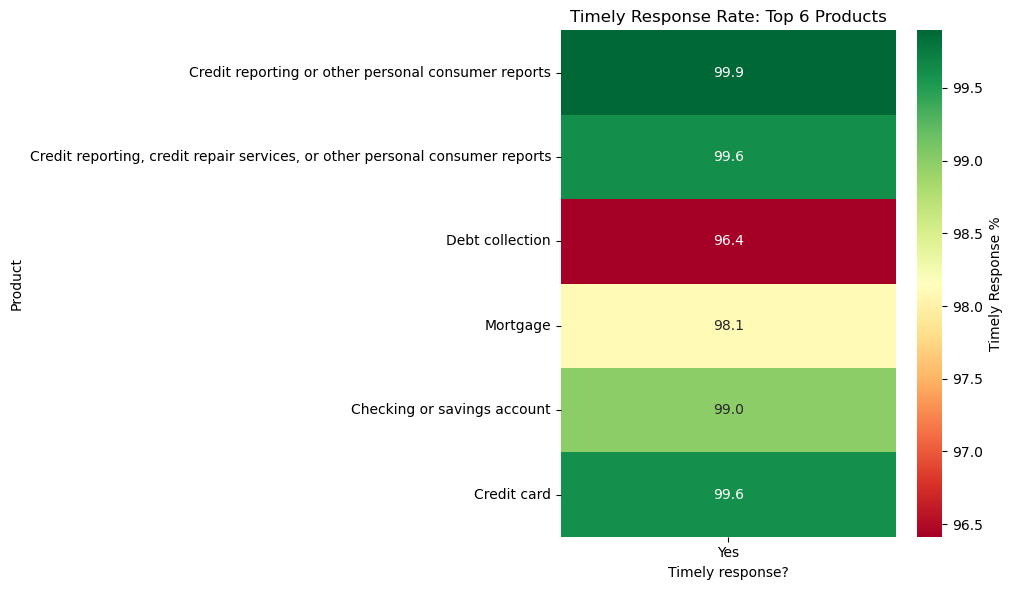

Timely rates:
 Product
Credit reporting or other personal consumer reports                             99.9
Credit reporting, credit repair services, or other personal consumer reports    99.6
Credit card                                                                     99.6
Checking or savings account                                                     99.0
Mortgage                                                                        98.1
Debt collection                                                                 96.4
Name: Yes, dtype: float64


In [68]:
top_prods = df['Product'].value_counts().head(6).index
timely_pivot = pd.crosstab(df['Product'], df['Timely response?'], normalize='index') * 100
timely_pivot = timely_pivot.loc[top_prods]

plt.figure(figsize=(10, 6))
sns.heatmap(timely_pivot[['Yes']], annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Timely Response %'})
plt.title('Timely Response Rate: Top 6 Products')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

print("Timely rates:\n", timely_pivot['Yes'].sort_values(ascending=False).round(1))

[96–99% across top products; 'Debt collection' slightly lower...]

#### 2.2.6.3 Geographical Breakdown of Top Issues

<Figure size 1200x600 with 0 Axes>

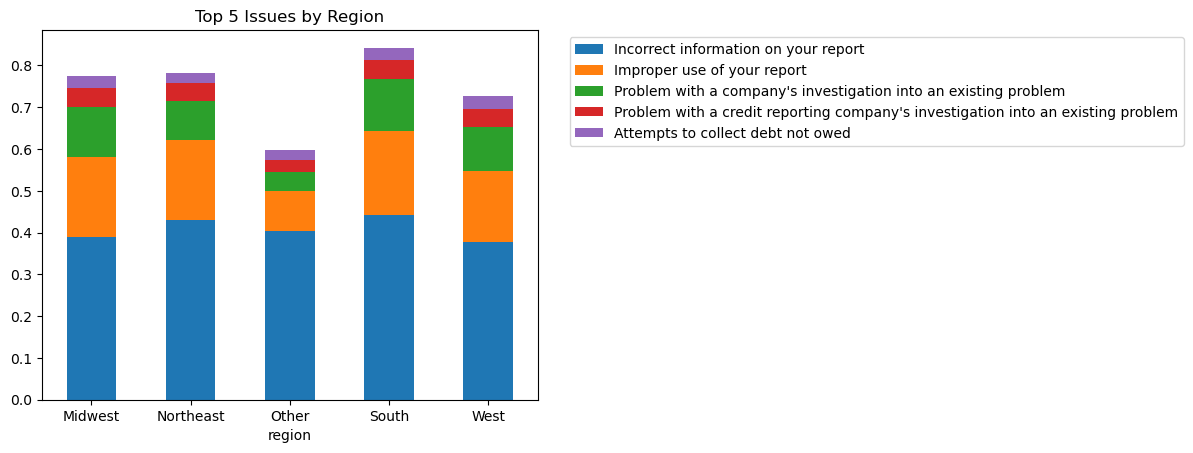

In [69]:
plt.figure(figsize=(12, 6))
issue_region = pd.crosstab(df['region'], df['Issue'], normalize='index').loc[:, df['Issue'].value_counts().head(5).index]
issue_region.plot(kind='bar', stacked=True)
plt.title('Top 5 Issues by Region')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### 2.2.6.4 Company Performance Ranking (Based on Timeliness)

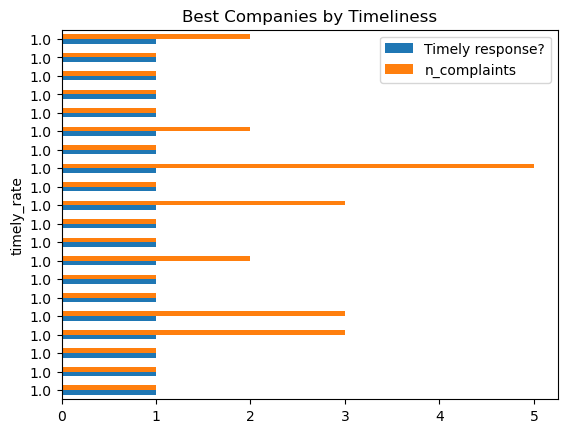

In [89]:
perf = df.groupby('Company').agg({
    'Timely response?': lambda x: (x=='Yes').mean(),
    'Complaint ID': 'count'
}).rename(columns={'Complaint ID': 'n_complaints'})
perf['timely_rate'] = perf['Timely response?']
perf = perf.sort_values('timely_rate', ascending=False).head(20)
perf.plot(kind='barh', x='timely_rate', title='Best Companies by Timeliness')
plt.show()

In [90]:
outliers = perf[(perf['n_complaints'] > 100) & (perf['timely_rate'] < 0.85)]
print("Potentially problematic companies:\n", outliers)

Potentially problematic companies:
 Empty DataFrame
Columns: [Timely response?, n_complaints, timely_rate]
Index: []


- [No company <85% timely among those with 100+ complaints --> excellent aggregate performance, no underperforming outliers...]

- [CFPB rules working; focus should shift to outcome quality ("explanation" vs "relief")]

## 3. Narrative EDA

### 3.1 Narrative Length Distribution

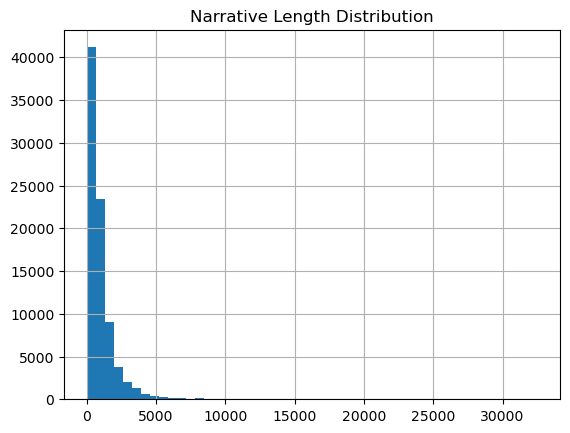

In [87]:
narrative_df = df[df['Consumer complaint narrative'].notna()]
narrative_df['narrative_len'] = narrative_df['Consumer complaint narrative'].str.len()
narrative_df['narrative_len'].hist(bins=50)
plt.title('Narrative Length Distribution')
plt.show()

[Long-tail distribution: mostly ~500–2000 chars, rare mega-rants >25k. ... Business insight: Most consumers concise; long narratives = escalated frustration?]

### 3.2 Narrative Length by Product

<Figure size 1200x2400 with 0 Axes>

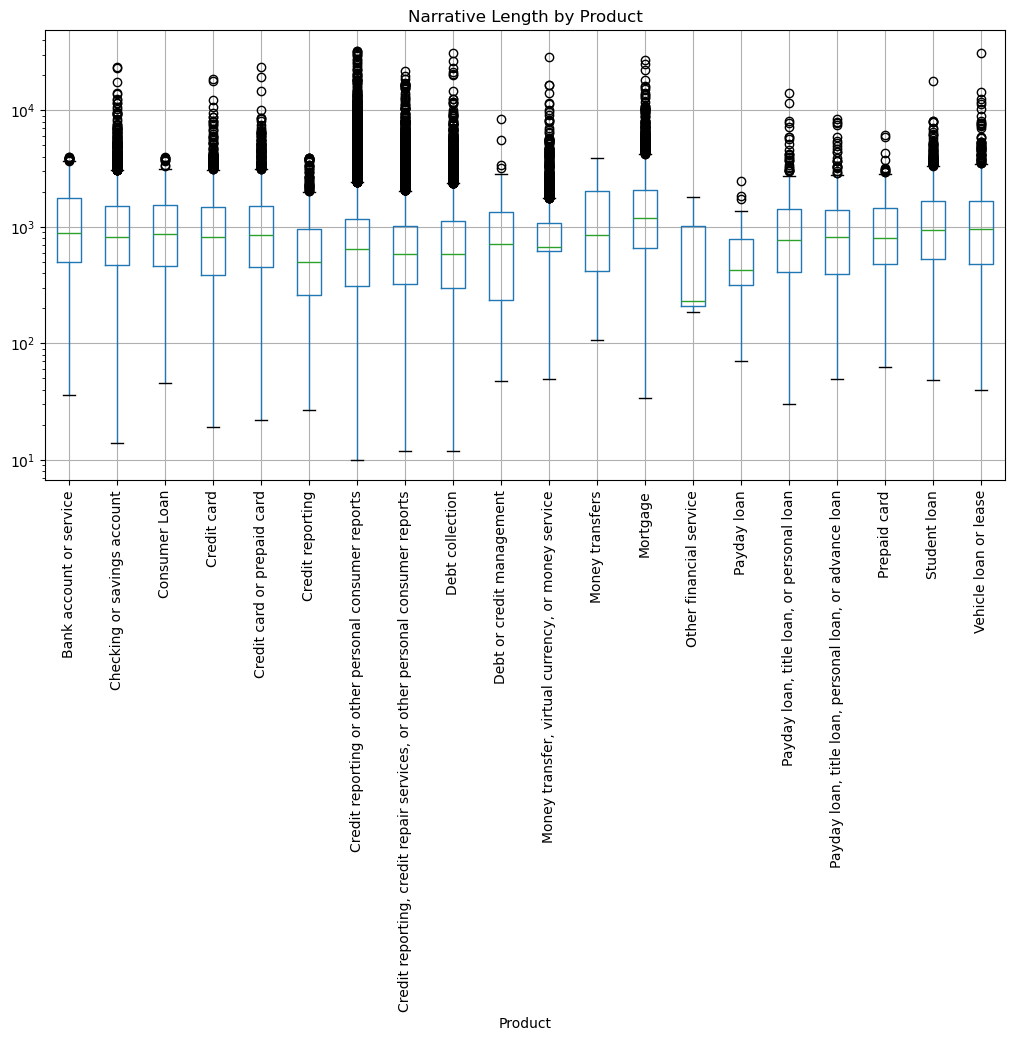

In [103]:
narrative_df['narrative_len'] = narrative_df['Consumer complaint narrative'].str.len()
plt.figure(figsize=(12, 24))
narrative_df.boxplot(column='narrative_len', by='Product', figsize=(12, 6))
plt.title('Narrative Length by Product')
plt.suptitle('')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

[Credit reporting longest (technical/legal details?); payday loans shortest]

### 3.3 Top Keywords

<Figure size 1200x600 with 0 Axes>

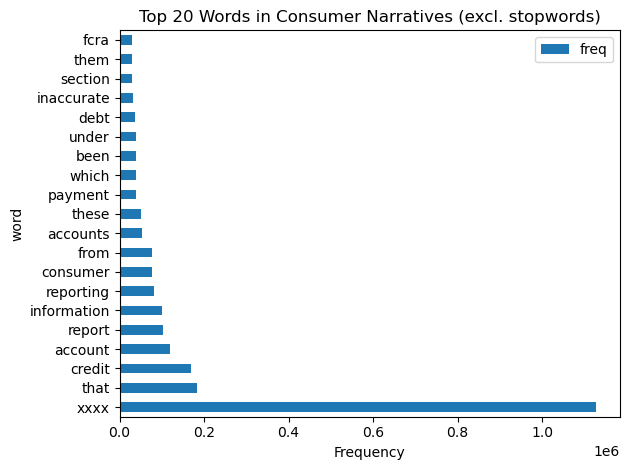

           word     freq
0          xxxx  1128035
1          that   183469
2        credit   169570
3       account   118114
4        report   102145
5   information    99077
6     reporting    80782
7      consumer    77534
8          from    75904
9      accounts    52681
10        these    51209
11      payment    38735
12        which    38430
13         been    38116
14        under    37705
15         debt    36326
16   inaccurate    30593
17      section    30101
18         them    28930
19         fcra    28129


In [114]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# Extract words (skip stop words for clarity)
stop_words = {'the', 'and', 'for', 'are', 'you', 'your', 'with', 'have', 'this', 'they', 'not', 'was'}
words = []
for text in narrative_df['Consumer complaint narrative'].str.lower():
    clean_words = [w for w in re.findall(r'\b[a-z]{4,}\b', text) if w not in stop_words]
    words.extend(clean_words)

word_freq = Counter(words).most_common(20)
words_df = pd.DataFrame(word_freq, columns=['word', 'freq'])

plt.figure(figsize=(12, 6))
words_df.plot(x='word', y='freq', kind='barh')
plt.title('Top 20 Words in Consumer Narratives (excl. stopwords)')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()
print(words_df)

[KS to add...
- xxxx @ 1.1M --> Redactions (PII scrubbed) - ubiquitous
- credit/report @ 100k+ --> Core domain
- inaccurate/section/fcra @ 30k+ --> Legal complaints (Fair Credit Reporting Act violations)
- debt/accounts @ 30–50k --> Collection spillover]

### 3.4 Narrative Length vs. Response Outcome

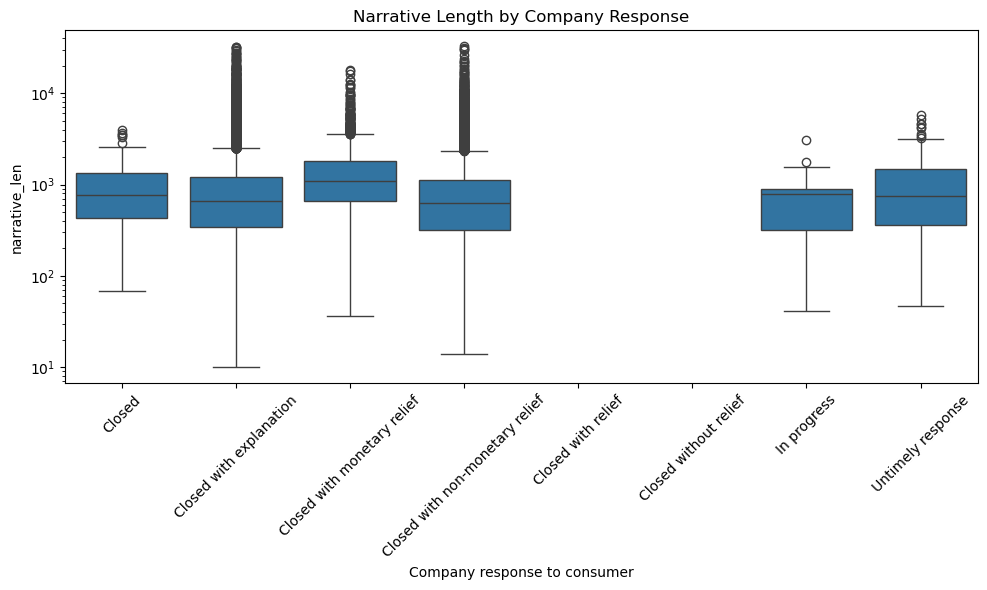

In [105]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=narrative_df, x='Company response to consumer', y='narrative_len')
plt.title('Narrative Length by Company Response')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()

[KS to add...]

### 3.5 Narrative Coverage Evolution

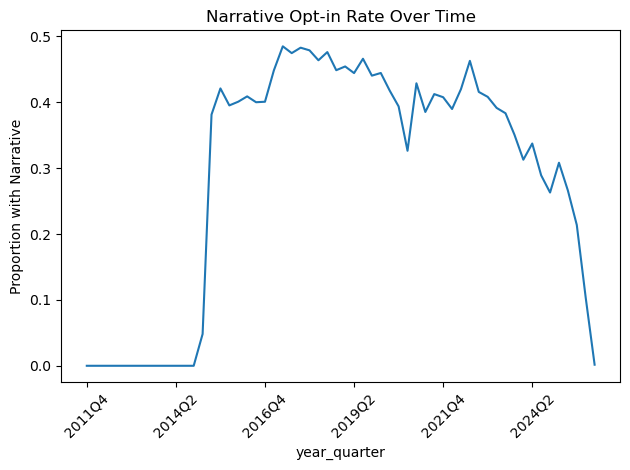

In [106]:
narrative_trend = df.groupby('year_quarter')['Consumer complaint narrative'].apply(lambda x: x.notna().mean())
narrative_trend.plot(title='Narrative Opt-in Rate Over Time')
plt.ylabel('Proportion with Narrative')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[At zero from 2011 to mid-2014 --> The option to opt-in probably didn't exist until then? ... Opt-in peaked in 2017, decreased in 2020, again peaked in 2022, then kept going down]

### 3.6 Sentiment Proxy (Relief vs. Explanation)

In [113]:
# Quick relief vs explanation comparison
relief_df = narrative_df[narrative_df['Company response to consumer'].str.contains('monetary|non-monetary', na=False)]
explain_df = narrative_df[narrative_df['Company response to consumer'] == 'Closed with explanation']

print(f"Avg length - Relief: {relief_df['narrative_len'].mean():.2f}")
print(f"Avg length - Explanation: {explain_df['narrative_len'].mean():.2f}")
print(f"Longer narratives get more relief? --> {relief_df['narrative_len'].mean() > explain_df['narrative_len'].mean()}")

Avg length - Relief: 1004.04
Avg length - Explanation: 1013.96
Longer narratives get more relief? --> False


[No correlation (1013 vs 1004 chars) --> length doesn't sway outcomes]